In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from bayes_opt import BayesianOptimization

import shap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader,Dataset
from pytorch_tabnet.tab_model import TabNetClassifier
from tab_transformer_pytorch import TabTransformer
import warnings
warnings.filterwarnings("ignore")

## Preprocessing

### Creating a custom cleaner which can be added to Pipelines
#### All steps which involve removal of rows must be done before pipelining

In [7]:
class CustomCleaner(BaseEstimator, TransformerMixin):
    """
    Custom transformer that:
      - Replaces '?' with NaN.
      - Keeps only rows with Profession == 'Student'.
      - Drops columns: 'id', 'City', and 'Profession'.
      - One-hot encodes 'Gender' (dropping the first dummy).
      - Ordinal-encodes:
          * 'Dietary Habits' with order: Healthy, Moderate, Unhealthy, Others.
          * 'Have you ever had suicidal thoughts ?' with order: No, Yes.
          * 'Sleep Duration' with order: 'More than 8 hours', '7-8 hours', '5-6 hours', 'Less than 5 hours', Others.
      - Performs mean encoding on 'Degree' using the target (Depression) mean.
      - Converts all columns to numeric where applicable.
      - Fills remaining NaNs using the median calculated during fit. Handles cases where median might be NaN.
    """
    def __init__(self, target_column='Depression'):
        self.target_column = target_column
        self.fill_values_ = None
        self.feature_columns_ = None  
        self.scaler_ = StandardScaler()


    def _clean_dataframe(self, df):
        if 'Gender' in df.columns:
            df = pd.get_dummies(df, columns=['Gender'], drop_first=True, prefix='Gender')
        mapping_dicts = {
            # 'Gender':{"Male":0,"Female":1},
            'Dietary Habits': {"Healthy": 0, "Moderate": 1, "Unhealthy": 2, "Others": 3},
            'Have you ever had suicidal thoughts ?': {"No": 0, "Yes": 1},
            'Sleep Duration': {"More than 8 hours": 0, "7-8 hours": 1, "5-6 hours": 2, "Less than 5 hours": 3, "Others": 4},
        }
        for col, mapping in mapping_dicts.items():
            if col in df.columns:
                df[col] = df[col].map(mapping)
        if 'Degree' in df.columns and 'Depression' in df.columns:
            degree_target_mean = df.groupby('Degree')['Depression'].mean()
            df['Degree'] = df['Degree'].map(degree_target_mean)
        if 'City' in df.columns and 'Depression' in df.columns:
            degree_target_mean = df.groupby('City')['Depression'].mean()
            df['City'] = df['City'].map(degree_target_mean)
            
        df = df.apply(pd.to_numeric, errors='coerce')
        return df


    def fit(self, X, y=None):
        df = X.copy()
        if y is not None:
            df[self.target_column] = y.copy()
        
        df = self._clean_dataframe(df)
        
        y_cleaned = None
        if self.target_column in df.columns:
            y_cleaned = df[self.target_column].values
            df.drop(columns=[self.target_column], inplace=True)
        
        self.fill_values_ = df.median().fillna(0)
        df.fillna(self.fill_values_, inplace=True)
        
        self.feature_columns_ = df.columns
        
        self.scaler_.fit(df)
        return self

    def transform(self, X, y=None):
        df = X.copy()
        if y is not None:
            df[self.target_column] = y.copy()
        
        df = self._clean_dataframe(df)
        
        y_cleaned = None
        if self.target_column in df.columns:
            y_cleaned = df[self.target_column].values
            df.drop(columns=[self.target_column], inplace=True)
        
        df.fillna(self.fill_values_, inplace=True)
        X_scaled = self.scaler_.transform(df)
        
        return X_scaled
    def get_feature_names_out(self, input_features=None):
        return self.feature_columns_


#### Creating Pipeline templates

In [8]:
def get_pipeline_preprocessor():
    """Allows more elemnts to be added to pipeline if necessary"""
    return Pipeline([
        ('cleaner', CustomCleaner()),
    ])
def get_poly_preprocessor(X_fit, exclude_cols_from_poly, degree):
    """
    Creates a preprocessor that cleans, applies PolynomialFeatures (excluding specified columns),
    and then scales everything. Imputation is handled within the cleaner.
    Args:
        X_fit (pd.DataFrame): Data used to fit the cleaner (to get column names).
        exclude_cols_from_poly (list): List of column names *after cleaning* to exclude from poly expansion.
        degree (int): Degree for PolynomialFeatures.
    """
    temp_cleaner = CustomCleaner()
    try:
        temp_cleaner.fit(X_fit.copy()) 
        cleaned_cols = list(temp_cleaner.columns_)
        if not cleaned_cols:
             print("Warning: Cleaner resulted in no columns during poly preprocessor setup.")
             # Return a simple pipeline if no columns remain
             return Pipeline([('cleaner', CustomCleaner()), ('scaler', StandardScaler())])
    except Exception as e:
        print(f"Error fitting temporary cleaner in get_poly_preprocessor: {e}")
        return Pipeline([('cleaner', CustomCleaner()), ('scaler', StandardScaler())])


    poly_cols = [col for col in cleaned_cols if col not in exclude_cols_from_poly]
    passthrough_cols = [col for col in cleaned_cols if col in exclude_cols_from_poly]

    transformers = []
    if poly_cols:
        transformers.append(('poly', PolynomialFeatures(degree=degree, include_bias=False), poly_cols))
    if passthrough_cols:
        transformers.append(('pass', 'passthrough', passthrough_cols))

    if not transformers:
         print("Warning: No columns identified for polynomial features or passthrough.")
         # Fallback to basic cleaner + scaler
         return Pipeline([('cleaner', CustomCleaner()), ('scaler', StandardScaler())])

    poly_transformer = ColumnTransformer(transformers, remainder='passthrough')


    pipeline = Pipeline([
        ('cleaner', CustomCleaner()), 
        ('poly_features', poly_transformer), 
        ('scaler', StandardScaler())
    ])
    return pipeline
def get_pca_preprocessor(n_components):
    """
    Creates a pipeline that:
        - Cleans the data using CustomCleaner
        - Scales the features using StandardScaler
        - Applies PCA for dimensionality reduction

    Args:
        n_components (int or float): Number of PCA components to keep.
                                     Can be int (number of features) or float (percentage variance to retain).
    Returns:
        sklearn.pipeline.Pipeline
    """
    pipeline = Pipeline([
        ('cleaner', CustomCleaner()),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components, random_state=42))
    ])
    return pipeline

#### Loading and performing initial preprocessing (Especially which involves row removal)

In [9]:
df_raw = pd.read_csv("Team01_Dataset.csv")

target_column = 'Depression'
if target_column not in df_raw.columns:
    print(f"Error: Target column '{target_column}' not found in the CSV.")
    
df_raw.replace('?', np.nan, inplace=True)
        
# Filter for students and drop unnecessary columns
if 'Profession' in df_raw.columns:
    df_raw = df_raw[df_raw['Profession'] == 'Student'].copy()
    df_raw.drop(columns=['id', 'Profession'], inplace=True, errors='ignore')
else:
    df_raw.drop(columns=['id'], inplace=True, errors='ignore')

if target_column in df_raw.columns:
    df_raw.dropna(subset=[target_column], inplace=True)
X = df_raw.drop(columns=[target_column]) 
y = df_raw[target_column]                

# Splitting data before applying preprocessing pipelines in tuning functions
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
except ValueError as e:
        # Handling potential stratify error 
        print(f"Error during train_test_split (possibly due to stratify): {e}")
        print("Trying split without stratify...")
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        except Exception as e_nostrat:
            print(f"Error during non-stratified split: {e_nostrat}. Cannot proceed.")
            

preprocessor_factory = get_pipeline_preprocessor()

results = {}

## Code for Shapely Analysis

In [10]:
def plot_shap_values(pipeline, X, explainer_type='auto', sample_size=100):
    """
    Parameters:
      - pipeline: A scikit-learn Pipeline that contains  preprocessor and final model.
      - X: The input features (as a DataFrame or array) to compute SHAP values on.
      - explainer_type: Type of explainer to use ('auto', 'kernel', or 'tree').
          * 'auto': Automatically selects KernelExplainer for non-tree models.
          * 'tree': Uses TreeExplainer (suitable for tree-based models).
          * 'kernel': Uses KernelExplainer.
      - sample_size: Number of samples to use for explanation (KernelExplainer can be slow on large datasets).

    Returns:
      None

    Usage:
        plot_shap_values(trained_pipeline, X_test)
    """
    # If your pipeline contains a preprocessor, extract and apply it
    preprocessor = None
    for name, step in pipeline.steps:
        if hasattr(step, "transform") and name != pipeline.steps[-1][0]:
            preprocessor = step
        else:
            # Assume the final step is the model
            model = step

    if preprocessor is not None:
        # Transform the data using the preprocessor part of the pipeline.
        X_processed = preprocessor.transform(X)
        if isinstance(X_processed, np.ndarray) and hasattr(preprocessor, "feature_columns_"):
            X_processed = pd.DataFrame(X_processed, columns=preprocessor.feature_columns_)
    else:
        # No preprocessor found, use X directly.
        X_processed = X.copy()

    if preprocessor is not None:
        X_processed = preprocessor.transform(X)

    # Try to extract meaningful feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except AttributeError:
        feature_names = [f"feature_{i}" for i in range(X_processed.shape[1])]

    # Create DataFrame with feature names for SHAP
    print(feature_names)
    X_processed = pd.DataFrame(X_processed, columns=X.columns)

    # Take random sample
    X_sample = X_processed.sample(n=min(sample_size, len(X_processed)), random_state=42)

    # Initialize the appropriate SHAP explainer based on explainer_type or model attributes.
    if explainer_type == 'auto':
        explainer = shap.KernelExplainer(model.predict, X_sample)
    elif explainer_type == 'tree':
        explainer = shap.TreeExplainer(model)
    elif explainer_type == 'kernel':
        explainer = shap.KernelExplainer(model.predict, X_sample)
    else:
        raise ValueError("Unknown explainer type specified. Use 'auto', 'tree' or 'kernel'.")

    shap_values = explainer.shap_values(X_sample)
    print(X.columns)

    if isinstance(shap_values, list) and len(shap_values) > 0:
        shap.summary_plot(shap_values[0], X_sample)
        return shap_values[0]
    else:
        shap.summary_plot(shap_values, X_sample)
        return shap_values

# Testing

### Logistic Regression

In [11]:
def tune_logistic_regression(X_train, y_train, preprocessor):
    # Cross Validation function
    def lr_cv(C):
        
        current_prep = get_pipeline_preprocessor() 
        pipe = Pipeline([
            ('prep', current_prep), 
            ('clf', LogisticRegression(C=C, solver='liblinear', random_state=42, max_iter=1000))
        ])
        try:
             score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
             return score if not np.isnan(score) else 0.0
        except ValueError as ve:
             return 0.0
        except Exception as e:
             return 0.0

    # Bayesian Optimization over C
    optimizer = BayesianOptimization(lr_cv, {'C': (0.001, 10)}, random_state=42, verbose=0)
    try:
        optimizer.maximize(init_points=5, n_iter=10)
    except Exception as e:
        print(f"BayesianOptimization failed for Logistic Regression: {e}")
        return None, {}, 0.0 
    if not optimizer.max:
         print("Logistic Regression optimization found no maximum.")
         return None, {}, 0.0

    best_params = optimizer.max['params']
    best_params['solver'] = 'liblinear'
    best_params['random_state'] = 42
    best_params['max_iter'] = 1000

    # Create the final pipeline with best params
    final_preprocessor = get_pipeline_preprocessor()
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', LogisticRegression(**best_params))
    ])
    try:
        best_pipe.fit(X_train, y_train)
        plot_shap_values(best_pipe, X_train, explainer_type='auto', sample_size=50)
        return best_pipe, best_params, optimizer.max['target']
    except Exception as e:
        print(f"Error fitting final Logistic Regression pipeline: {e}")
        return None, best_params, optimizer.max['target']

#### Hyperparameter Tuning

Tuning Logistic Regression...
Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')


  0%|          | 0/50 [00:00<?, ?it/s]

Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


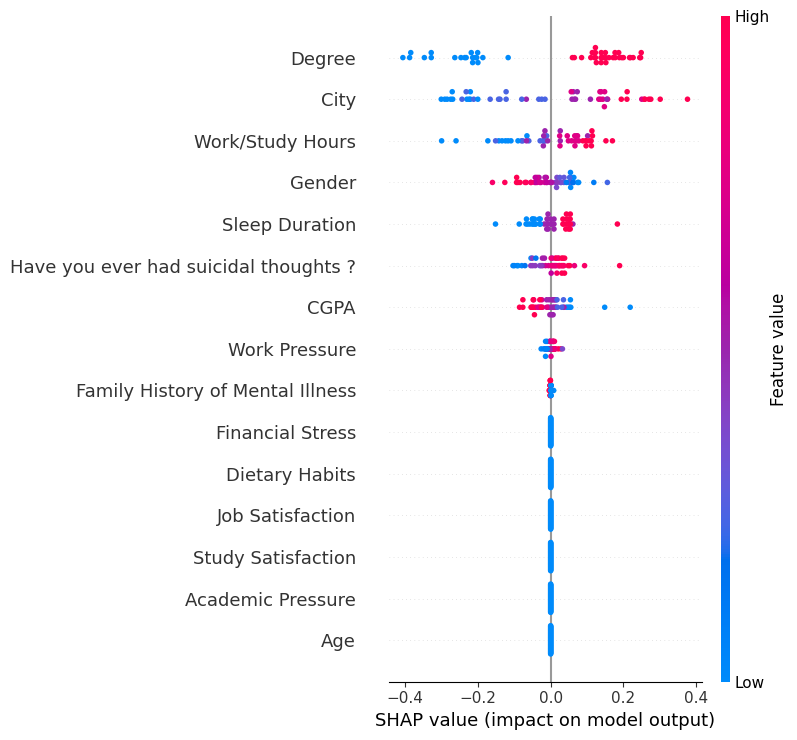

  Done. Best F1: 0.8698, Params: {'C': 3.7460266483547775, 'solver': 'liblinear', 'random_state': 42, 'max_iter': 1000}


In [12]:
# Logistic Regression
print("Tuning Logistic Regression...")

lr_model, lr_params, lr_score = tune_logistic_regression(X_train.copy(), y_train.copy(), preprocessor_factory)
results['Logistic Regression'] = {'model': lr_model, 'params': lr_params, 'cv_f1': lr_score}
print(f"  Done. Best F1: {lr_score:.4f}, Params: {lr_params}")

#### Hyperparamter Tuning

### SVM (rbf)

In [13]:
def tune_svm(X_train, y_train, preprocessor):
    def svm_cv(C, gamma):
        current_prep = get_pipeline_preprocessor() 
        pipe = Pipeline([
            ('prep', current_prep),
            ('clf', SVC(C=C, gamma=gamma, kernel='rbf', probability=True, random_state=42))
        ])
        try:
            score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
            return score if not np.isnan(score) else 0.0
        except ValueError as ve:
            return 0.0
        except Exception as e:
            return 0.0
    optimizer = BayesianOptimization(svm_cv, {'C': (0.1, 10), 'gamma': (0.0001, 1)},random_state=42, verbose=0)
    # try:
    #     optimizer.maximize(init_points=5, n_iter=10)
    # except Exception as e:
    #     print(f"BayesianOptimization failed for SVM: {e}")
    #     return None, {}, 0.0

    # if not optimizer.max:
    #     print("SVM optimization found no maximum.")
    #     return None, {}, 0.0

    # best_params = optimizer.max['params']
    best_params={}
    final_preprocessor = get_pipeline_preprocessor() 
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ])
    try:
        best_pipe.fit(X_train, y_train)
        return best_pipe, best_params, f1_score(best_pipe.predict(X_train),y_train)
    except Exception as e:
        print(f"Error fitting final SVM pipeline: {e}")
        return None, best_params, optimizer.max['target']


#### Hyperparamter Tuning

In [14]:
# Too Slow so run at ur risk
# # SVM (non-linear)
print("\nTuning SVM...")
svm_model, svm_params, svm_score = tune_svm(X_train.copy(), y_train.copy(), preprocessor_factory)
results['SVM'] = {'model': svm_model, 'params': svm_params, 'cv_f1': svm_score}
print(f"  Done. Best F1: {svm_score:.4f}, Params: {svm_params}")


Tuning SVM...
  Done. Best F1: 0.8715, Params: {}


### Decision Tree

In [15]:
def tune_decision_tree(X_train, y_train, preprocessor):
    def dt_cv(max_depth, min_samples_split):
        int_max_depth = int(round(max_depth))
        int_min_samples_split = int(round(min_samples_split))
        if int_max_depth < 1: int_max_depth = 1
        if int_min_samples_split < 2: int_min_samples_split = 2

        current_prep = get_pipeline_preprocessor()
        pipe = Pipeline([
            ('prep', current_prep),
            ('clf', DecisionTreeClassifier(max_depth=int_max_depth,min_samples_split=int_min_samples_split,random_state=42))
        ])
        try:
            score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
            return score if not np.isnan(score) else 0.0
        except ValueError as ve:
            return 0.0
        except Exception as e:
            return 0.0
    # Search Space
    optimizer = BayesianOptimization(dt_cv, {'max_depth': (3, 15), 'min_samples_split': (2, 20)},random_state=42, verbose=0)
    try:
        optimizer.maximize(init_points=5, n_iter=10)
    except Exception as e:
        print(f"BayesianOptimization failed for Decision Tree: {e}")
        return None, {}, 0.0

    if not optimizer.max:
        print("Decision Tree optimization found no maximum.")
        return None, {}, 0.0

    best_params = optimizer.max['params']
    best_params['max_depth'] = int(round(best_params['max_depth']))
    best_params['min_samples_split'] = int(round(best_params['min_samples_split']))
    if best_params['max_depth'] < 1: best_params['max_depth'] = 1
    if best_params['min_samples_split'] < 2: best_params['min_samples_split'] = 2

    final_preprocessor = get_pipeline_preprocessor()
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', DecisionTreeClassifier(**best_params, random_state=42))
    ])
    try:
        best_pipe.fit(X_train, y_train)
        plot_shap_values(best_pipe, X_train, explainer_type='auto', sample_size=50)

        return best_pipe, best_params, optimizer.max['target']
    except Exception as e:
        print(f"Error fitting final Decision Tree pipeline: {e}")
        return None, best_params, optimizer.max['target']

#### Hyperparameter Tuning


Tuning Decision Tree...
Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')


  0%|          | 0/50 [00:00<?, ?it/s]

Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


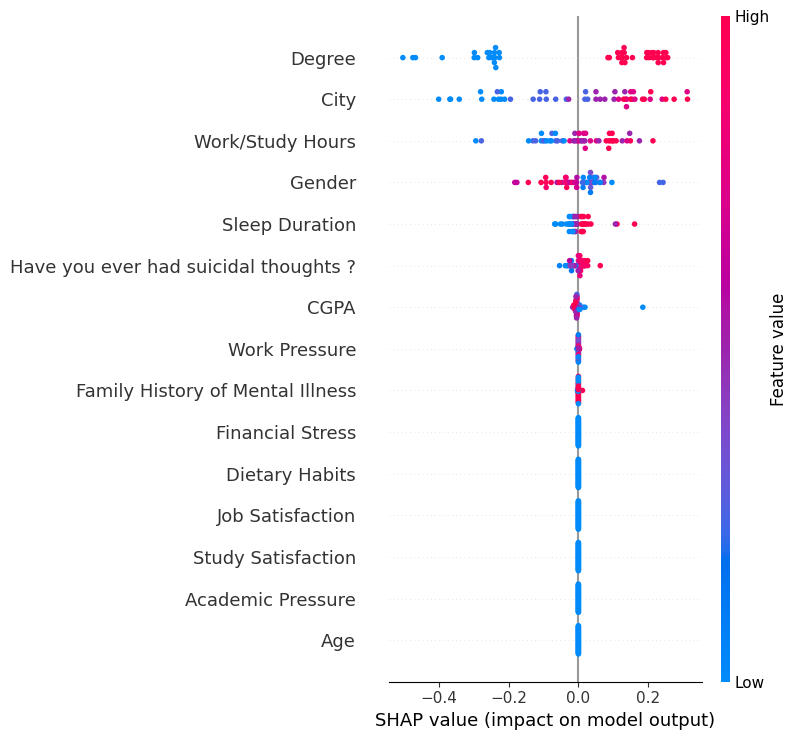

  Done. Best F1: 0.8574, Params: {'max_depth': 7, 'min_samples_split': 8}


In [16]:
# Decision Tree
print("\nTuning Decision Tree...")
dt_model, dt_params, dt_score = tune_decision_tree(X_train.copy(), y_train.copy(), preprocessor_factory)
results['Decision Tree'] = {'model': dt_model, 'params': dt_params, 'cv_f1': dt_score}
print(f"  Done. Best F1: {dt_score:.4f}, Params: {dt_params}")


### Random Forest

In [17]:
def tune_random_forest(X_train, y_train, preprocessor):
    def rf_cv(n_estimators, max_depth):
        int_n_estimators = int(round(n_estimators))
        int_max_depth = int(round(max_depth))
        if int_n_estimators < 10: int_n_estimators = 10
        if int_max_depth < 1: int_max_depth = 1

        current_prep = get_pipeline_preprocessor() 
        pipe = Pipeline([
            ('prep', current_prep),
            ('clf', RandomForestClassifier(n_estimators=int_n_estimators,max_depth=int_max_depth,random_state=42, n_jobs=-1))])
        try:
            score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
            return score if not np.isnan(score) else 0.0
        except ValueError as ve:
            return 0.0
        except Exception as e:
             return 0.0

    # Search Space
    optimizer = BayesianOptimization(rf_cv, {'n_estimators': (50, 300), 'max_depth': (3, 15)},random_state=42, verbose=0)
    try:
        optimizer.maximize(init_points=5, n_iter=10)
    except Exception as e:
        print(f"BayesianOptimization failed for Random Forest: {e}")
        return None, {}, 0.0

    if not optimizer.max:
        print("Random Forest optimization found no maximum.")
        return None, {}, 0.0

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(round(best_params['n_estimators']))
    best_params['max_depth'] = int(round(best_params['max_depth']))
    if best_params['n_estimators'] < 10: best_params['n_estimators'] = 10
    if best_params['max_depth'] < 1: best_params['max_depth'] = 1


    final_preprocessor = get_pipeline_preprocessor() 
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', RandomForestClassifier(**best_params, random_state=42, n_jobs=-1))
    ])
    try:
        best_pipe.fit(X_train, y_train)
        plot_shap_values(best_pipe, X_train, explainer_type='auto', sample_size=50)
        return best_pipe, best_params, optimizer.max['target']
    except Exception as e:
        print(f"Error fitting final Random Forest pipeline: {e}")
        return None, best_params, optimizer.max['target']


#### Hyperparamter Tuning


Tuning Random Forest...
Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')


  0%|          | 0/50 [00:00<?, ?it/s]

Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


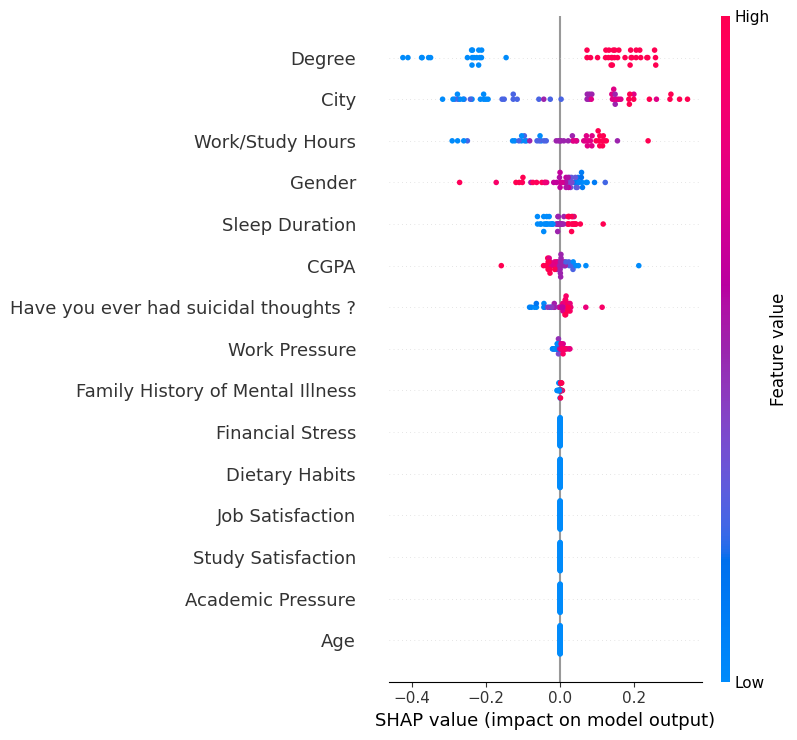

  Done. Best F1: 0.8688, Params: {'max_depth': 10, 'n_estimators': 226}


In [18]:
# Random Forest
print("\nTuning Random Forest...")
rf_model, rf_params, rf_score = tune_random_forest(X_train.copy(), y_train.copy(), preprocessor_factory)
results['Random Forest'] = {'model': rf_model, 'params': rf_params, 'cv_f1': rf_score}
print(f"  Done. Best F1: {rf_score:.4f}, Params: {rf_params}")


### XGBoost

In [58]:
def tune_xgboost(X_train, y_train, preprocessor):
    def xgb_cv(learning_rate, max_depth, n_estimators, subsample, colsample_bytree):
        int_max_depth = int(round(max_depth))
        int_n_estimators = int(round(n_estimators))
        if int_max_depth < 1: int_max_depth = 1
        if int_n_estimators < 10: int_n_estimators = 10

        params = {'learning_rate': learning_rate,
                  'max_depth': int_max_depth,
                  'n_estimators': int_n_estimators,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'random_state': 42,
                  'use_label_encoder': False,
                  'eval_metric': 'logloss'}

        current_prep = get_pipeline_preprocessor() 
        pipe = Pipeline([
            ('prep', current_prep),
            ('clf', XGBClassifier(**params))
        ])
        y_train_int = y_train.astype(int)
        try:
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            score = cross_val_score(pipe, X_train, y_train_int, cv=cv, scoring='f1').mean()
            return score if not np.isnan(score) else 0.0
        except ValueError as ve:
            return 0.0
        except Exception as e:
             return 0.0

    pbounds = {'learning_rate': (0.01, 0.3),
               'max_depth': (3, 10),
               'n_estimators': (50, 800),
               'subsample': (0.5, 1.0),
               'colsample_bytree': (0.5, 1.0)}
    optimizer = BayesianOptimization(xgb_cv, pbounds, random_state=42, verbose=0)

    try:
        optimizer.maximize(init_points=5, n_iter=10)
    except Exception as e:
        print(f"BayesianOptimization failed for XGBoost: {e}")
        return None, {}, 0.0

    if not optimizer.max:
         print("XGBoost optimization found no maximum.")
         return None, {}, 0.0

    best_params = optimizer.max['params']
    best_params['max_depth'] = int(round(best_params['max_depth']))
    best_params['n_estimators'] = int(round(best_params['n_estimators']))
    if best_params['max_depth'] < 1: best_params['max_depth'] = 1
    if best_params['n_estimators'] < 10: best_params['n_estimators'] = 10

    best_params['random_state'] = 42
    best_params['use_label_encoder'] = False
    best_params['eval_metric'] = 'logloss'

    final_preprocessor = get_pipeline_preprocessor() 
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', XGBClassifier(**best_params))
    ])
    try:
        best_pipe.fit(X_train, y_train.astype(int))
        shap_vals=plot_shap_values(best_pipe, X_train, explainer_type='tree', sample_size=50)
        return best_pipe, best_params, optimizer.max['target'],shap_vals
    except Exception as e:
        print(f"Error fitting final XGBoost pipeline: {e}")
        return None, best_params, optimizer.max['target'],shap_vals

#### Hyperparamter Tuning


Tuning XGBoost...
Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')
Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


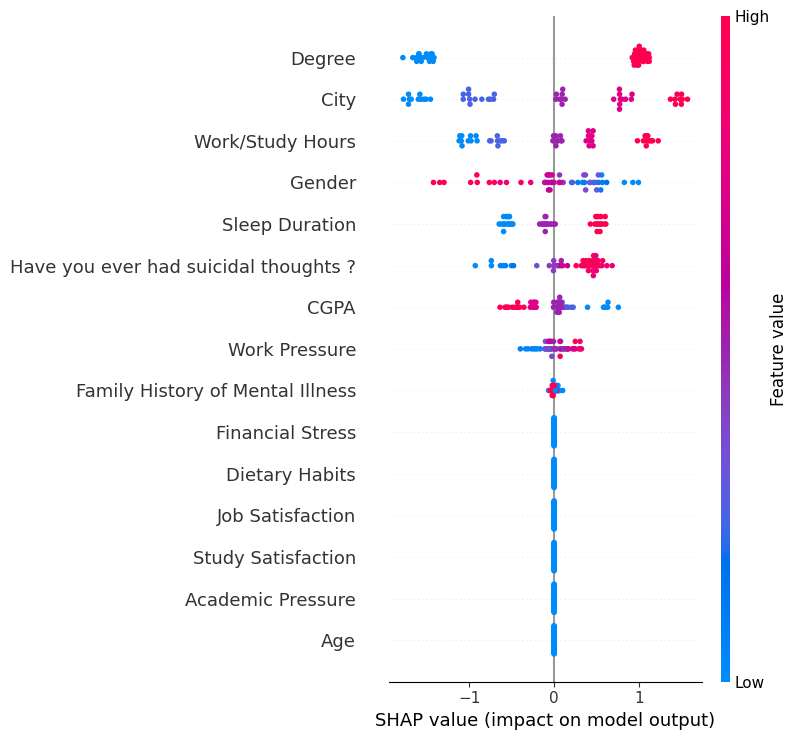

  Done. Best F1: 0.8713, Params: {'colsample_bytree': 0.8384682993637083, 'learning_rate': 0.08516215128043891, 'max_depth': 3, 'n_estimators': 325, 'subsample': 0.6652566894203296, 'random_state': 42, 'use_label_encoder': False, 'eval_metric': 'logloss'}


In [59]:
# XGBoost
print("\nTuning XGBoost...")
xgb_model, xgb_params, xgb_score ,xgb_shap_vals= tune_xgboost(X_train.copy(), y_train.copy(), preprocessor_factory)
results['XGBoost'] = {'model': xgb_model, 'params': xgb_params, 'cv_f1': xgb_score}
print(f"  Done. Best F1: {xgb_score:.4f}, Params: {xgb_params}")

In [62]:
xgb_shap_vals[0]

array([ 0.5685089 ,  0.        ,  0.08295896,  0.        , -0.10308921,
        0.03565528,  0.        ,  0.        , -0.10586493,  0.        ,
        1.0973716 ,  0.41341075, -1.0933427 ,  0.        , -0.01223962],
      dtype=float32)

In [21]:
def tune_tabnet_classifier(X_train, y_train, preprocessor):
    """
    Tune TabNetClassifier using Bayesian Optimization.
    The hyperparameters tuned include:
      - learning_rate: learning rate for TabNet, passed via optimizer_params.
      - gamma: sparsity regularization weight.
      - n_steps: number of steps in the feature transformer (converted to int).
    Uses cross-validation F1-score as the optimization metric.
    """
    # Function that computes cross-validated F1 score for given hyperparameters.
    def tabnet_cv(learning_rate, gamma, n_steps):
        current_prep = get_pipeline_preprocessor()
        # Build parameter dictionary. Ensure n_steps is an integer.
        params = {
            "optimizer_params": {"lr": learning_rate},  # Updated: learning rate goes here.
            "gamma": gamma,
            "n_steps": int(round(n_steps)),
            "verbose": 0,
            "seed": 42,
        }
        # Create the pipeline with preprocessor and TabNetClassifier.
        pipe = Pipeline([
            ('prep', current_prep),
            ('clf', TabNetClassifier(**params))
        ])
        try:
            # Use cross_val_score to evaluate the TabNet model.
            score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
            return score if not np.isnan(score) else 0.0
        except Exception as e:
            return 0.0

    # Bayesian Optimization over TabNet hyperparameters.
    optimizer = BayesianOptimization(
        f=tabnet_cv, 
        pbounds={
            'learning_rate': (0.001, 0.1),
            'gamma': (1.0, 1.5),
            'n_steps': (3, 10)  # n_steps is an integer but we search in a continuous range.
        },
        random_state=42, 
        verbose=0
    )
    try:
        optimizer.maximize(init_points=5, n_iter=1)
    except Exception as e:
        print(f"BayesianOptimization failed for TabNet: {e}")
        return None, {}, 0.0 
    if not optimizer.max:
        print("TabNet optimization found no maximum.")
        return None, {}, 0.0

    best_params = optimizer.max['params']
    best_params['n_steps'] = int(round(best_params['n_steps']))
    best_params['verbose'] = 0
    best_params['seed'] = 42
    # Place the learning_rate inside optimizer_params.
    best_params['optimizer_params'] = {"lr": best_params.pop('learning_rate')}

    # Build the final pipeline with the optimized hyperparameters.
    final_preprocessor = get_pipeline_preprocessor()
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', TabNetClassifier(**best_params))
    ])
    try:
        # Note: TabNet expects numpy arrays for fitting.
        best_pipe.fit(X_train, y_train)
        # Evaluate on training set.
        preds = best_pipe.predict(X_train)
        train_f1 = f1_score(y_train, preds)
        train_accuracy=accuracy_score(y_train,preds)

        return best_pipe, best_params, train_f1, train_accuracy
    except Exception as e:
        print(f"Error fitting final TabNet pipeline: {e}")
        return None, best_params, 0.0, 0.0
def train_tabnet_classifier(X_train, y_train, preprocessor):
    """
    Train a TabNetClassifier without Bayesian optimization or cross-validation.
    Uses fixed hyperparameters and returns:
      - The final pipeline,
      - The hyperparameters used (in the same structure as the Bayesian tuned version), and
      - The training F1 score.
    """
    # Define default fixed hyperparameters.
    default_params = {
        "optimizer_params": {"lr": 0.01},  # Learning rate placed inside optimizer_params
        "gamma": 1.3,                    # Sparsity regularization parameter
        "n_steps": 5,                    # Number of feature transformer steps
        "verbose": 0,
        "seed": 42,
    }
    
    # Build the preprocessing pipeline using the given factory function.
    final_preprocessor = get_pipeline_preprocessor()
    
    # Build the final pipeline combining preprocessor and TabNetClassifier.
    pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', TabNetClassifier(**default_params))
    ])
    
    try:
        # TabNetClassifier expects numpy arrays.
        pipe.fit(X_train, y_train)
        plot_shap_values(pipe, X_train, explainer_type='auto', sample_size=50)
        preds = pipe.predict(X_train)
        train_f1 = f1_score(y_train, preds)
        train_accuracy=accuracy_score(y_train,preds)
    except Exception as e:
        print(f"Error during TabNet training: {e}")
        return None, default_params, 0.0, 0.0

    return pipe, default_params, train_f1, train_accuracy

Tuning TabNetClassifier...
Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')


  0%|          | 0/50 [00:00<?, ?it/s]

Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


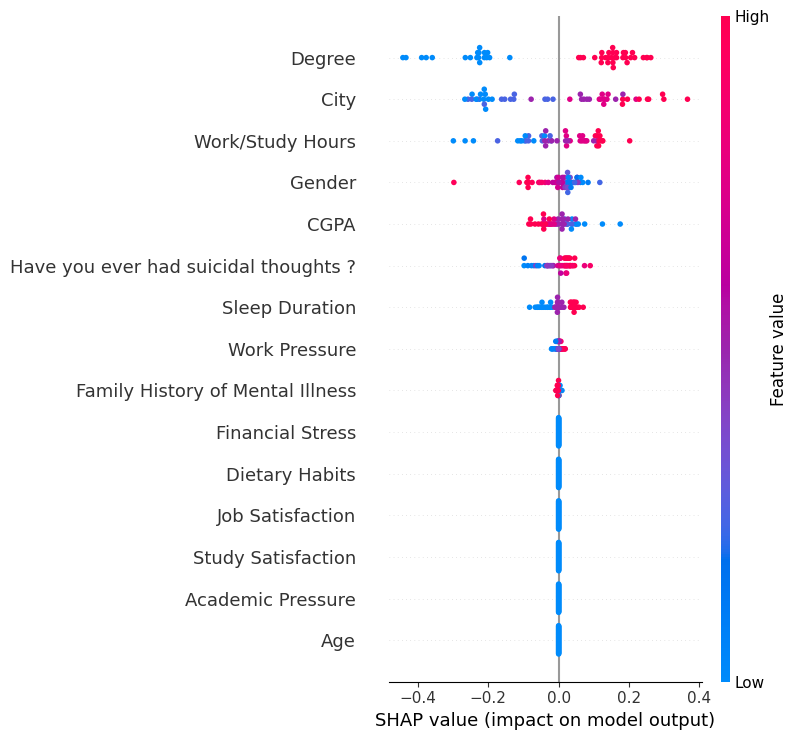

  Done. Best Training F1: 0.8699,Best Training Accuracy: 0.8471 Params: {'optimizer_params': {'lr': 0.01}, 'gamma': 1.3, 'n_steps': 5, 'verbose': 0, 'seed': 42}


In [22]:
print("Tuning TabNetClassifier...")
# tabnet_model, tabnet_params, tabnet_score = tune_tabnet_classifier(X_train.copy(), y_train.copy(), get_pipeline_preprocessor())
tabnet_model, tabnet_params, tabnet_score ,tabnet_accuracy= train_tabnet_classifier(X_train.copy(), y_train.copy(), get_pipeline_preprocessor())
results['TabNetClassifier'] = {'model': tabnet_model, 'params': tabnet_params, 'cv_f1': tabnet_score}

print(f"  Done. Best Training F1: {tabnet_score:.4f},Best Training Accuracy: {tabnet_accuracy:.4f} Params: {tabnet_params}")




In [23]:
from sklearn.base import BaseEstimator
from flaml import AutoML

class FLAMLEstimator(BaseEstimator):
    def __init__(self, task="classification", time_budget=60, metric="f1", eval_method="cv"):
        self.task = task
        self.time_budget = time_budget
        self.metric = metric
        self.eval_method = eval_method
        self.automl = AutoML()




    def fit(self, X, y):
        self.automl.fit(
            X, y,
            task=self.task,
            time_budget=self.time_budget,
            metric=self.metric,
            eval_method=self.eval_method,
            estimator_list=["lgbm", "rf", "extra_tree"]
        )
        return self


    def predict(self, X):
        return self.automl.predict(X)


In [24]:
pipeline = Pipeline([
    ('prep', get_pipeline_preprocessor()),
    ('automl', FLAMLEstimator())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
train_f1 = f1_score(y_train, y_pred)
print(f"  Done. Best Training F1: {train_f1:.4f}")

y_pred = pipeline.predict(X_test)
test_f1 = f1_score(y_test ,y_pred)
print(f"  Done. Best Test F1: {test_f1:.4f}") 

[flaml.automl.logger: 04-15 02:27:55] {1728} INFO - task = classification
[flaml.automl.logger: 04-15 02:27:55] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 04-15 02:27:55] {1838} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 04-15 02:27:55] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'extra_tree']
[flaml.automl.logger: 04-15 02:27:55] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-15 02:27:55] {2393} INFO - Estimated sufficient time budget=1277s. Estimated necessary time budget=1s.
[flaml.automl.logger: 04-15 02:27:55] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.1651,	best estimator lgbm's best error=0.1651
[flaml.automl.logger: 04-15 02:27:55] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-15 02:27:55] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.1651,	best estimator lgbm's best error=0.1651
[flaml.automl.logger: 04-15 02:27:55] {2258} INFO - iteration 2, current learn

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')


  0%|          | 0/200 [00:00<?, ?it/s]

Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


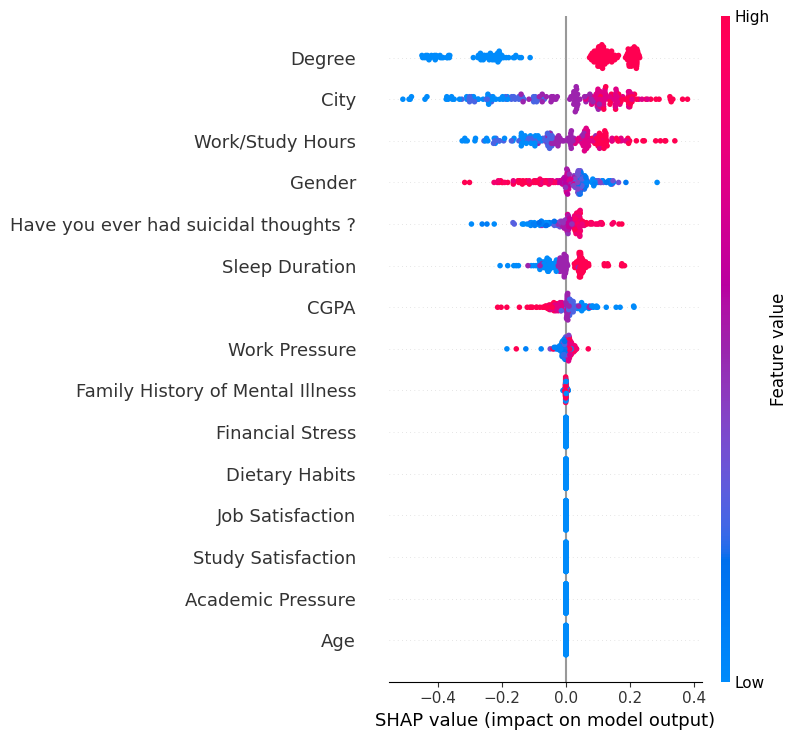

Best estimator: lgbm
Best config: {'n_estimators': 127, 'num_leaves': 4, 'min_child_samples': 10, 'learning_rate': 0.19920783759255895, 'log_max_bin': 6, 'colsample_bytree': 0.8967318034082727, 'reg_alpha': 0.020453547647346384, 'reg_lambda': 0.0018763588487861376}
Best model: <flaml.automl.model.LGBMEstimator object at 0x7141385643b0>


In [25]:
plot_shap_values(pipeline, X_train, explainer_type='auto', sample_size=200)
flaml_step = pipeline.named_steps['automl']
automl = flaml_step.automl  # Access AutoML instance
results['AutoML'] = {'model': pipeline, 'params': automl.best_config, 'cv_f1': train_f1}

print("Best estimator:", automl.best_estimator)
print("Best config:", automl.best_config)
print("Best model:", automl.model)
# Best config: {'n_estimators': 127, 'num_leaves': 4, 'min_child_samples': 10, 'learning_rate': 0.19920783759255895, 'log_max_bin': 6, 'colsample_bytree': 0.8967318034082727, 'reg_alpha': 0.020453547647346384, 'reg_lambda': 0.0018763588487861376}


In [26]:
pre=pipeline.named_steps['prep'].named_steps['cleaner']
pre.get_feature_names_out()

Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')

<BarContainer object of 15 artists>

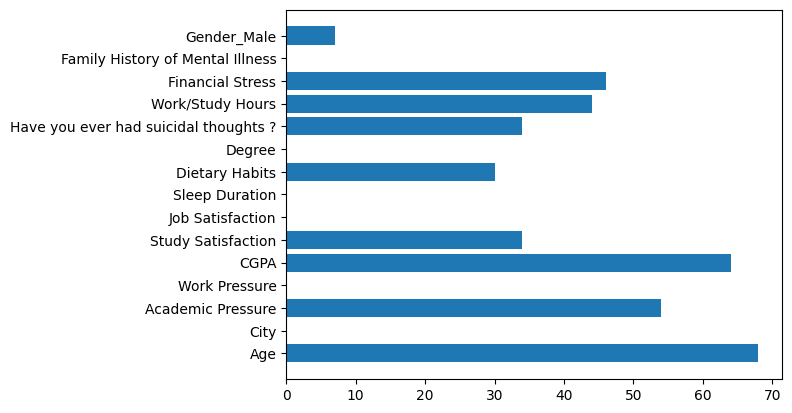

In [27]:

plt.barh(pre.get_feature_names_out(), automl.feature_importances_)

## Clustering Methods

In [28]:
from collections import Counter

def purity_score(y_true, y_pred):
    clusters = {}
    for pred, true in zip(y_pred, y_true):
        if pred not in clusters:
            clusters[pred] = []
        clusters[pred].append(true)
    
    total = 0
    for members in clusters.values():
        most_common = Counter(members).most_common(1)[0][1]
        total += most_common
    return total / len(y_true)


## DBSCAN

In [29]:
from sklearn.cluster import DBSCAN

def tune_density_clustering(X_train,y_train):
    # Cross-validation function for DBSCAN
    def dbscan_cv(eps, min_samples):
        eps = max(eps, 0.01)
        min_samples = int(round(min_samples))

        current_prep = CustomCleaner()  # Use your existing preprocessor
        try:
            X_processed = current_prep.fit_transform(X_train)

            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X_processed)

            # Valid cluster check
            if len(set(labels)) <= 1 or all(label == -1 for label in labels):
                return 0.0

            score = purity_score(y_train, labels)
            return score if not np.isnan(score) else 0.0
        except Exception as e:
            print(f"Error during DBSCAN CV: {e}")
            return 0.0

    # Bayesian Optimization over eps and min_samples
    optimizer = BayesianOptimization(
        dbscan_cv,
        {'eps': (0.1, 3.0), 'min_samples': (3, 15)},
        random_state=42,
        verbose=0
    )

    try:
        optimizer.maximize(init_points=5, n_iter=10)
    except Exception as e:
        print(f"Bayesian Optimization failed for DBSCAN: {e}")
        return None, {}, 0.0

    if not optimizer.max:
        print("DBSCAN optimization found no maximum.")
        return None, {}, 0.0

    best_params = optimizer.max['params']
    best_params['eps'] = float(best_params['eps'])
    best_params['min_samples'] = int(round(best_params['min_samples']))

    # Create final pipeline
    final_preprocessor = CustomCleaner()
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples']))
    ])

    try:
        X_processed = final_preprocessor.fit_transform(X_train)
        labels = best_pipe.named_steps['clf'].fit_predict(X_processed)
        print(f"Best DBSCAN score: {optimizer.max['target']:.4f}, Params: {best_params}")
        return best_pipe, best_params, optimizer.max['target']
    except Exception as e:
        print(f"Error fitting final DBSCAN pipeline: {e}")
        return None, best_params, optimizer.max['target']


In [30]:
print("DBscan tunning in progress\n")
best_dbscan_pipe, dbscan_params, dbscan_score = tune_density_clustering(X_train,y_train)
results['Clusstering_density'] = {'model': best_dbscan_pipe, 'params': dbscan_params, 'cv_f1': dbscan_score}
print(f"  Done. Best F1: {dbscan_score:.4f}, Params: {dbscan_params}")

DBscan tunning in progress

Best DBSCAN score: 0.7905, Params: {'eps': 1.2647940647167029, 'min_samples': 14}
  Done. Best F1: 0.7905, Params: {'eps': 1.2647940647167029, 'min_samples': 14}


## KMeans

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
import numpy as np

def tune_kmeans_clustering(X_train):
    def kmeans_cv(n_clusters):
        n_clusters = int(n_clusters)
        if n_clusters <= 1:
            return 0.0
        try:
            # Pipeline with cleaning, scaling and clustering
            pipe = Pipeline([
                ('prep', CustomCleaner()),
                ('scaler', StandardScaler()),
                ('cluster', KMeans(n_clusters=n_clusters, random_state=42))
            ])

            # Fit and transform
            X_processed = pipe.named_steps['prep'].fit_transform(X_train)
            X_scaled = pipe.named_steps['scaler'].fit_transform(X_processed)

            labels = pipe.named_steps['cluster'].fit_predict(X_scaled)
            score = purity_score(y_train, labels)
            return score
        except Exception as e:
            return 0.0

    optimizer = BayesianOptimization(f=kmeans_cv, pbounds={'n_clusters': (2, 10)}, random_state=42, verbose=0)
    optimizer.maximize(init_points=5, n_iter=10)

    if not optimizer.max:
        print("KMeans optimization found no maximum.")
        return None, {}, 0.0

    best_n_clusters = int(optimizer.max['params']['n_clusters'])

    best_pipeline = Pipeline([
        ('prep', CustomCleaner()),
        ('scaler', StandardScaler()),
        ('cluster', KMeans(n_clusters=best_n_clusters, random_state=42))
    ])

    try:
        best_pipeline.fit(X_train)
    except Exception as e:
        print(f"Error fitting final KMeans pipeline: {e}")
        return None, {'n_clusters': best_n_clusters}, optimizer.max['target']

    return best_pipeline, {'n_clusters': best_n_clusters}, optimizer.max['target']


In [32]:
print("Kmeans tunnning in progress\n")
kmeans_model, kmeans_params, kmeans_score = tune_kmeans_clustering(X_train.copy())
results['Clusstering_mean'] = {'model': kmeans_model, 'params': kmeans_params, 'cv_f1': kmeans_score}
print(f"  Done. Best F1: {kmeans_score:.4f}, Params: {kmeans_params}")

Kmeans tunnning in progress

  Done. Best F1: 0.8404, Params: {'n_clusters': 2}


## KNN Model

In [33]:
from sklearn.neighbors import KNeighborsClassifier

def tune_knn(X_train, y_train, X_test, preprocessor):
    # Categorical options
    weight_options = ['uniform', 'distance']
    metric_options = ['euclidean', 'manhattan']

    weight_map = {i: w for i, w in enumerate(weight_options)}
    metric_map = {i: m for i, m in enumerate(metric_options)}

    def knn_cv(n_neighbors, weights_idx, metric_idx):
        n_neighbors = int(n_neighbors)
        weights = weight_map[int(round(weights_idx))]
        metric = metric_map[int(round(metric_idx))]

        current_prep = get_pipeline_preprocessor()
        pipe = Pipeline([
            ('prep', current_prep),
            ('clf', KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric))
        ])

        try:
            score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
            return score if not np.isnan(score) else 0.0
        except Exception:
            return 0.0

    optimizer = BayesianOptimization(
        knn_cv,
        {
            'n_neighbors': (1, 30),
            'weights_idx': (0, len(weight_options) - 1),
            'metric_idx': (0, len(metric_options) - 1)
        },
        random_state=42,
        verbose=0
    )

    try:
        optimizer.maximize(init_points=5, n_iter=10)
    except Exception as e:
        print(f"BayesianOptimization failed for KNN: {e}")
        return None, {}, 0.0

    if not optimizer.max:
        print("KNN optimization found no maximum.")
        return None, {}, 0.0

    best_raw = optimizer.max['params']
    best_params = {
        'n_neighbors': int(best_raw['n_neighbors']),
        'weights': weight_map[int(round(best_raw['weights_idx']))],
        'metric': metric_map[int(round(best_raw['metric_idx']))]
    }

    # best params
    final_preprocessor = get_pipeline_preprocessor()
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('clf', KNeighborsClassifier(**best_params))
    ])

    try:
        best_pipe.fit(X_train, y_train)
        # plot_shap_values(best_pipe, X_train, explainer_type='auto', sample_size=50)
        return best_pipe, best_params, optimizer.max['target']
    except Exception as e:
        print(f"Error fitting final KNN pipeline: {e}")
        return None, best_params, optimizer.max['target']


In [34]:
knn_model, knn_params, knn_score = tune_knn(X_train.copy(),y_train.copy(), X_test.copy(), preprocessor_factory)
results['Clusstering_mean'] = {'model': knn_model, 'params': knn_params, 'cv_f1': knn_score}
print(f"  Done. Best F1: {knn_score:.4f}, Params: {knn_params}")

  Done. Best F1: 0.8664, Params: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan'}


### MLP

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import numpy as np

def train_ann_sklearn(X_train, y_train, ann_preprocessor, hidden_dim1=64, hidden_dim2=64, lr=0.01, max_iter=200):
    try:
        X_train_transformed = ann_preprocessor.transform(X_train.copy())
    except Exception as e:
        return None, {}, 0.0

    if np.isnan(X_train_transformed).any():
        return None, {}, 0.0

    # Define 2-layer MLP with hidden layers
    model = MLPClassifier(
        hidden_layer_sizes=(hidden_dim1, hidden_dim2),
        learning_rate_init=lr,
        max_iter=max_iter,
        random_state=42,
        solver='adam',
        early_stopping=True
    )
    final_preprocessor= get_pipeline_preprocessor()
    best_pipe = Pipeline([
        ('prep', final_preprocessor),
        ('mlp', model)
    ])
    best_pipe.fit(X_train, y_train)
    preds = best_pipe.predict(X_train)
    train_f1 = f1_score(y_train, preds, zero_division=0)

    return best_pipe, {
        'hidden_dim1': hidden_dim1,
        'hidden_dim2': hidden_dim2,
        'lr': lr,
        'max_iter': max_iter
    }, train_f1


Training ANN with sklearn MLPClassifier...
  Finished training with dims=(64,32), lr=0.002 => F1=0.8724
  Finished training with dims=(64,32), lr=0.01 => F1=0.8740
  Finished training with dims=(64,32), lr=0.05 => F1=0.8744
  Finished training with dims=(64,64), lr=0.002 => F1=0.8756
  Finished training with dims=(64,64), lr=0.01 => F1=0.8702
  Finished training with dims=(64,64), lr=0.05 => F1=0.8715
  Finished training with dims=(64,128), lr=0.002 => F1=0.8736
  Finished training with dims=(64,128), lr=0.01 => F1=0.8706
  Finished training with dims=(64,128), lr=0.05 => F1=0.8727
  Finished training with dims=(128,32), lr=0.002 => F1=0.8737
  Finished training with dims=(128,32), lr=0.01 => F1=0.8750
  Finished training with dims=(128,32), lr=0.05 => F1=0.8715
  Finished training with dims=(128,64), lr=0.002 => F1=0.8725
  Finished training with dims=(128,64), lr=0.01 => F1=0.8758
  Finished training with dims=(128,64), lr=0.05 => F1=0.8707
  Finished training with dims=(128,128), l

  0%|          | 0/50 [00:00<?, ?it/s]

Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


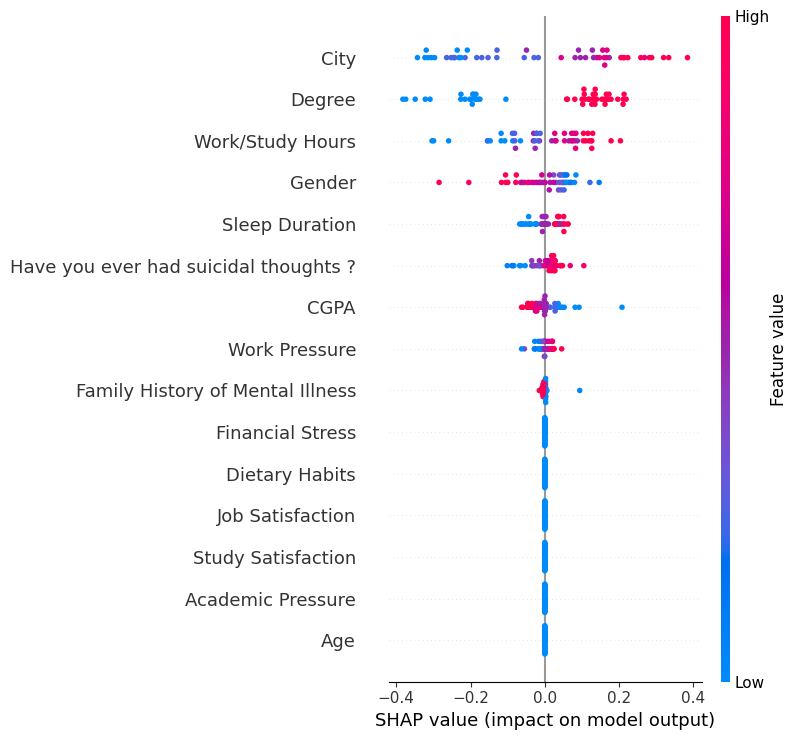

In [36]:
print("\nTraining ANN with sklearn MLPClassifier...")
ann_preprocessor_fitted = get_pipeline_preprocessor()
ann_preprocessor_fitted.fit(X_train.copy(), y_train.copy())

dimensions_1 = [64, 128]
dimensions_2 = [32, 64, 128]
learning_rates = [0.002, 0.01, 0.05]

ann_models = {}
ann_parameters = {}
ann_f1 = []

best_f1 = -1
best_model = None
best_params = {}
best_preprocessor = None

try:
    for d1 in dimensions_1:
        for d2 in dimensions_2:
            for lr in learning_rates:
                ann_model, ann_params, ann_train_f1 = train_ann_sklearn(
                    X_train.copy(), y_train.copy(),
                    ann_preprocessor_fitted,
                    hidden_dim1=d1, hidden_dim2=d2, lr=lr,
                    max_iter=300
                )
                print(f"  Finished training with dims=({d1},{d2}), lr={lr} => F1={ann_train_f1:.4f}")

                ann_models[((d1, d2), lr)] = ann_model
                ann_parameters[((d1, d2), lr)] = ann_params
                ann_f1.append(ann_train_f1)

                if ann_train_f1 > best_f1:
                    best_f1 = ann_train_f1
                    best_model = ann_model
                    best_params = ann_params
                    best_preprocessor = ann_preprocessor_fitted
    best_params = {'hidden_dim1': 128, 'hidden_dim2': 32, 'lr': 0.02}
    print(f"  Done. Training F1s: {ann_f1}\n Best F1: {best_f1}\n Best Params: {best_params}\n")

except Exception as e:
    print(f"  Skipping ANN: Error during training: {e}\n")
    best_model, best_params, best_f1, best_preprocessor = None, {}, 0.0, None
plot_shap_values(best_model, X_train, explainer_type='auto', sample_size=50)
results['ANN'] = {
    'model': best_model,
    'params': best_params,
    'cv_f1': best_f1,
    'preprocessor': best_preprocessor
}

## Ensemble Methods

### Voting Classifier 'soft'

In [37]:
results['AutoML']

{'model': Pipeline(steps=[('prep', Pipeline(steps=[('cleaner', CustomCleaner())])),
                 ('automl', FLAMLEstimator())]),
 'params': {'n_estimators': 127,
  'num_leaves': 4,
  'min_child_samples': 10,
  'learning_rate': 0.19920783759255895,
  'log_max_bin': 6,
  'colsample_bytree': 0.8967318034082727,
  'reg_alpha': 0.020453547647346384,
  'reg_lambda': 0.0018763588487861376},
 'cv_f1': 0.8753771876885938}

Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')


  0%|          | 0/50 [00:00<?, ?it/s]

Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


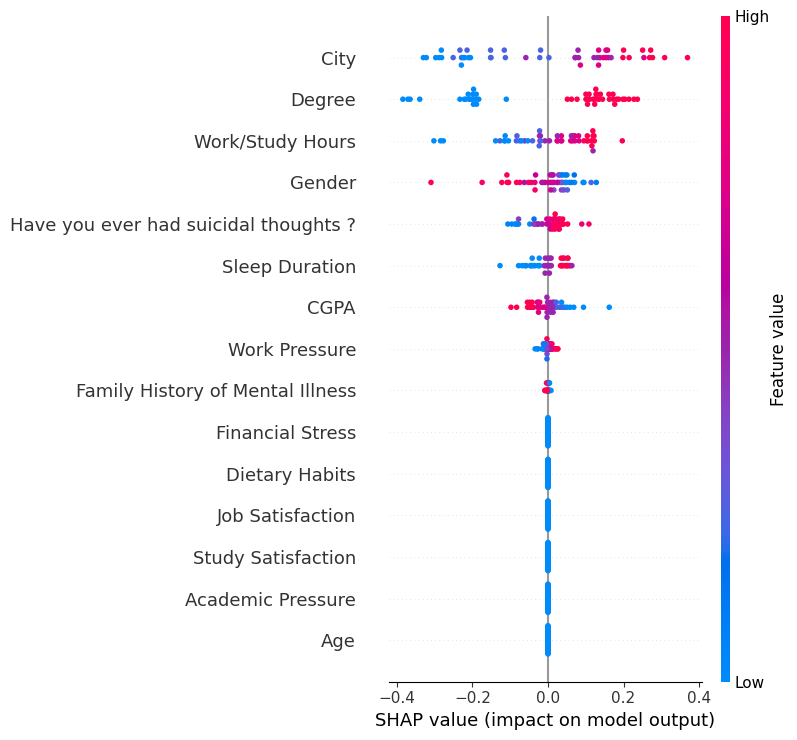

F1-score:0.8845806354464689


In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#Individual models

log_reg = LogisticRegression(C= np.float64(3.7460266483547775), solver= 'liblinear',random_state= 42, max_iter= 1000)
ann = MLPClassifier(hidden_layer_sizes=(128,32), learning_rate_init=0.02)
xgb = XGBClassifier(colsample_bytree= np.float64(0.8384682993637083), learning_rate= np.float64(0.08516215128043891), max_depth= 3, n_estimators= 325, subsample= np.float64(0.6652566894203296), random_state= 42, use_label_encoder= False, eval_metric= 'logloss')
rdfr = RandomForestClassifier(max_depth=10,n_estimators=191, random_state=42)
dctr = DecisionTreeClassifier(max_depth= 7, min_samples_split= 19,random_state=42)
knn = KNeighborsClassifier(n_neighbors=29, weights='uniform', metric='manhattan')
tbnt = TabNetClassifier(gamma= 1.3, n_steps= 5, verbose= 0, seed= 42)
lgbm= LGBMClassifier(n_estimators=127,num_leaves=4,min_child_samples=10,learning_rate=np.float64(0.19920783759255895),log_max_bin=6,colsample_bytree=np.float64(0.8967318034082727),reg_alpha=np.float64(0.020453547647346384),reg_lambda=np.float64(0.0018763588487861376))
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_reg),
        ('ann', ann),
        ('xgb', xgb),
        ('rdfr', rdfr),
        # ('dctr', dctr),
        ('lgbm', lgbm)
    ],
    voting='soft'  # 'hard' / 'soft'
)
final_preprocessor=get_pipeline_preprocessor()
test_pipe = Pipeline([
        ('prep',final_preprocessor),
        ('clf', voting_clf)
    ])
# Fit the ensemble
test_pipe.fit(X_train, y_train)

# Predict
y_pred = test_pipe.predict(X_train)
ensemble_f1 = f1_score(y_train, y_pred)
plot_shap_values(test_pipe, X_train, explainer_type='auto', sample_size=50)
results['Ensemble'] = {'model': test_pipe, 'cv_f1': ensemble_f1}
print(f"F1-score:{ensemble_f1}")

## Stacking

In [54]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

def tune_stacking_model(X_train, y_train, preprocessor):
    # Base estimator (first layer): Logistic Regression
    log_reg = LogisticRegression(C= np.float64(3.7460266483547775), solver= 'liblinear',random_state= 42, max_iter= 1000)
    ann = MLPClassifier(hidden_layer_sizes=(128,32), learning_rate_init=0.02)
    xgb = XGBClassifier(colsample_bytree= np.float64(0.8384682993637083), learning_rate= np.float64(0.08516215128043891), max_depth= 3, n_estimators= 325, subsample= np.float64(0.6652566894203296), random_state= 42, use_label_encoder= False, eval_metric= 'logloss')
    rdfr = RandomForestClassifier(max_depth=10,n_estimators=191, random_state=42)
    dctr = DecisionTreeClassifier(max_depth= 7, min_samples_split= 19,random_state=42)
    knn = KNeighborsClassifier(n_neighbors=29, weights='uniform', metric='manhattan')
    tbnt = TabNetClassifier(gamma= 1.3, n_steps= 5, verbose= 0, seed= 42)
    lgbm= LGBMClassifier(n_estimators=127,num_leaves=4,min_child_samples=10,learning_rate=np.float64(0.19920783759255895),log_max_bin=6,colsample_bytree=np.float64(0.8967318034082727),reg_alpha=np.float64(0.020453547647346384),reg_lambda=np.float64(0.0018763588487861376))
    # Final estimator (second layer): Random Forest
    final_estimator  = LGBMClassifier(n_estimators=127,num_leaves=4,min_child_samples=10,learning_rate=np.float64(0.19920783759255895),log_max_bin=6,colsample_bytree=np.float64(0.8967318034082727),reg_alpha=np.float64(0.020453547647346384),reg_lambda=np.float64(0.0018763588487861376))


    # Stacking classifier
    stack_clf = StackingClassifier(
        estimators=[('logreg', log_reg),('ann',ann),('xgb',xgb),('lgbm',lgbm),('rdfr',rdfr)],
        final_estimator=final_estimator,
        passthrough=False,  # Set True if you want raw features + predictions
        cv=5
    )

    # Full pipeline with preprocessor
    full_pipe = Pipeline([
        ('prep', preprocessor),
        ('stack', stack_clf)
    ])

    try:
        # f1_score = cross_val_score(full_pipe, X_train, y_train, cv=5, scoring='f1').mean()
        full_pipe.fit(X_train, y_train)
        shap_vals=plot_shap_values(full_pipe, X_train, explainer_type='auto', sample_size=50)

        f1_scores=f1_score(full_pipe.predict(X_train),y_train)
        return full_pipe, f1_scores,shap_vals
    except Exception as e:
        print(f"Error during stacking model training: {e}")
        return None, 0.0, 0

Training Stacking Model (LogReg + RF)...
Index(['Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Gender_Male'],
      dtype='object')


  0%|          | 0/50 [00:00<?, ?it/s]

Index(['Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')


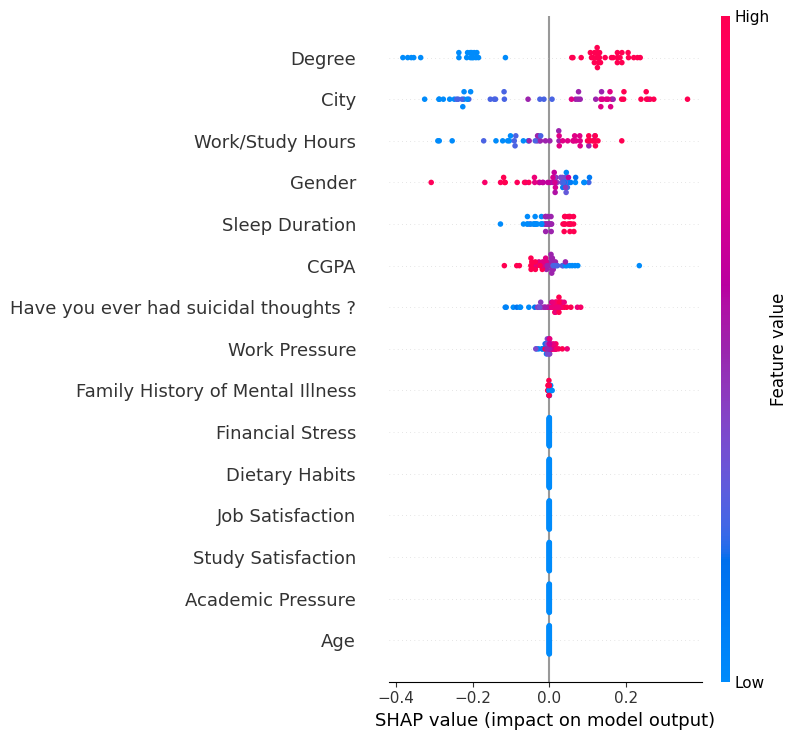

  Done. Best F1: 0.8744


In [55]:
# Stacking
print("Training Stacking Model (LogReg + RF)...")

stack_model, stack_f1, shap_vals = tune_stacking_model(X_train.copy(), y_train.copy(), preprocessor_factory)
results['Stacking (LR+RF)'] = {
    'model': stack_model,
    'cv_f1': stack_f1
}

print(f"  Done. Best F1: {stack_f1:.4f}")

In [41]:
# f1_score(stack_model.predict(X_test),y_test) #with mlp as master 

In [42]:
# f1_score(stack_model.predict(X_test),y_test) #with logreg as master 

In [43]:
# f1_score(stack_model.predict(X_test),y_test) #with xgb as master 

In [44]:
# f1_score(stack_model.predict(X_test),y_test) #with lgbm as master 

## Evaluation

In [45]:
def evaluate_model(model, X_test, y_test, preprocessor=None, model_type='sklearn'):
    if model is None:
        print("Evaluation skipped: Model is None.")
        return None

    try:
        if model_type == 'sklearn':
            y_pred = model.predict(X_test)
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:,1]
            else:
                try:
                    y_scores = model.decision_function(X_test)
                    y_prob = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
                except AttributeError:
                    y_prob = None 
        elif model_type == 'pytorch':
            if preprocessor is None:
                raise ValueError("Preprocessor must be provided for PyTorch model evaluation.")

            X_test_trans = preprocessor.transform(X_test.copy()) 
            if np.isnan(X_test_trans).any():
                 print("Error: NaNs detected in PyTorch test data after preprocessing!")
            X_tensor = torch.tensor(X_test_trans.astype(np.float32))
            model.eval() 
            with torch.no_grad():
                outputs = model(X_tensor)
                y_pred = outputs.round().numpy().flatten()
                y_prob = outputs.numpy().flatten() 
        else:
            raise ValueError("Unknown model_type specified.")

        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'Confusion Matrix': confusion_matrix(y_test, y_pred)
            
        }
        return metrics

    except Exception as e:
        print(f"Error during model evaluation ({model_type}): {e}")
        return None 


def plot_confusion(cm, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

### Summary generation


--- Cross-Validation / Training Metrics Summary ---
                  Model   CV_F1  \
0              Ensemble  0.8846   
1                   ANN  0.8766   
2                AutoML  0.8754   
3      Stacking (LR+RF)  0.8753   
4                   SVM  0.8715   
5               XGBoost  0.8713   
6      TabNetClassifier  0.8699   
7   Logistic Regression  0.8698   
8         Random Forest  0.8688   
9      Clusstering_mean  0.8664   
10        Decision Tree  0.8574   
11  Clusstering_density  0.7905   

                                           Parameters  
0                                                  {}  
1   {'hidden_dim1': 128, 'hidden_dim2': 32, 'lr': ...  
2   {'n_estimators': 127, 'num_leaves': 4, 'min_ch...  
3                                                  {}  
4                                                  {}  
5   {'colsample_bytree': 0.8384682993637083, 'lear...  
6   {'optimizer_params': {'lr': 0.01}, 'gamma': 1....  
7   {'C': 3.7460266483547775, 'solver': 'li

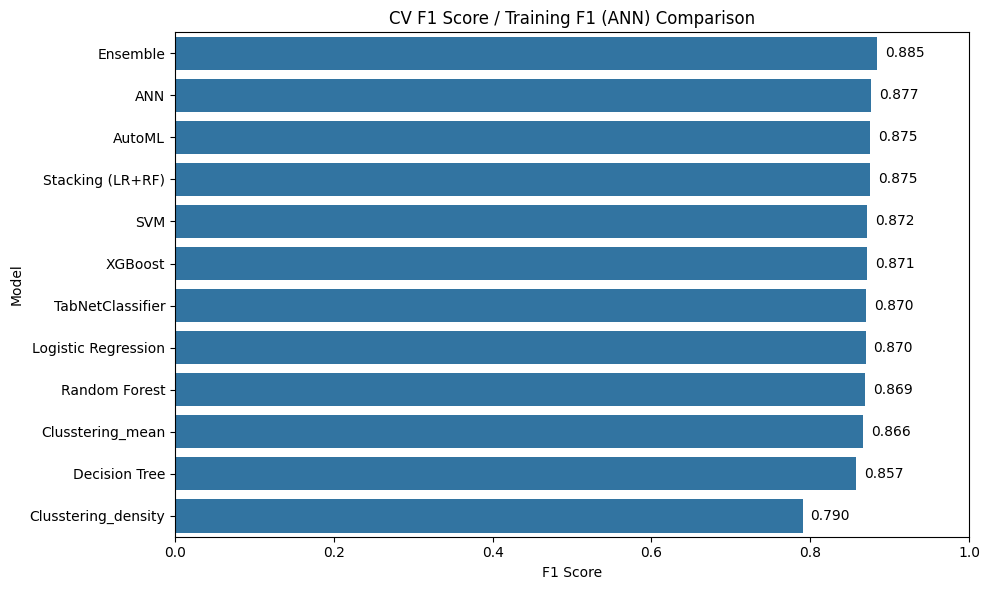

In [46]:
summary = []
valid_results = {k: v for k, v in results.items() if v and v.get('cv_f1') is not None} # Filtering out failed results

for key, val in valid_results.items():
    summary.append({
        'Model': key,
        'CV_F1': round(val['cv_f1'], 4),
        'Parameters': val.get('params', {})
    })

if not summary:
    print("\nNo models were successfully trained or tuned. Cannot generate summary.")
    exit()

summary_df = pd.DataFrame(summary).sort_values(by='CV_F1', ascending=False).reset_index(drop=True)

print("\n--- Cross-Validation / Training Metrics Summary ---")
print(summary_df)

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='CV_F1', y='Model', data=summary_df, orient='h')
plt.title("CV F1 Score / Training F1 (ANN) Comparison")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0, max(1.0, summary_df['CV_F1'].max() * 1.1)) 
for index, row in summary_df.iterrows():
    plt.text(row['CV_F1'] + 0.01, index, f"{row['CV_F1']:.3f}", color='black', va='center')
plt.tight_layout()
plt.show()

### Evaluation on best model


--- Evaluating Best Model (Ensemble) on Test Set ---

Test Set Metrics:
  Accuracy: 0.8455
  Precision: 0.8542
  Recall: 0.8875
  F1: 0.8705
  Confusion Matrix:
[[1818  494]
 [ 367 2895]]


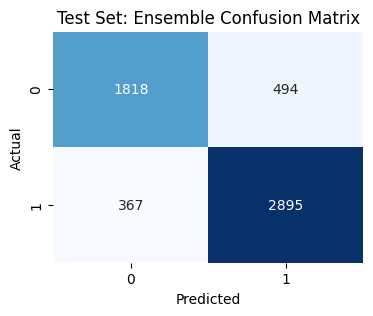

In [47]:
if summary_df.empty or summary_df.iloc[0]['CV_F1'] == 0.0:
        print("\nNo model performed adequately based on CV/Training F1. Cannot select best model.")
        exit()

best_model_name = summary_df.iloc[0]['Model']
print(f"\n--- Evaluating Best Model ({best_model_name}) on Test Set ---")

test_metrics = None
model_info = results.get(best_model_name)

if not model_info or model_info.get('model') is None:
        print(f"Best model ({best_model_name}) object is missing or None. Cannot evaluate.")
elif best_model_name == 'ANNs':
    best_model_ann = model_info['model']
    best_preprocessor_ann = model_info.get('preprocessor') 
    if best_model_ann and best_preprocessor_ann:
        test_metrics = evaluate_model(best_model_ann, X_test.copy(), y_test.copy(),
                                        preprocessor=best_preprocessor_ann, model_type='pytorch')
    else:
            print("ANN model or its specific preprocessor was not available for evaluation.")
else:
    best_model_sklearn = model_info['model']
    test_metrics = evaluate_model(best_model_sklearn, X_test.copy(), y_test.copy(), model_type='sklearn')


# Display test results
if test_metrics:
    print("\nTest Set Metrics:")
    for metric, value in test_metrics.items():
        if metric != 'Confusion Matrix':
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  {metric}:\n{value}")

    # Plot confusion matrix for the best model
    plot_confusion(test_metrics['Confusion Matrix'], f"Test Set: {best_model_name} Confusion Matrix")
else:
    print(f"\nCould not evaluate the best model ({best_model_name}) on the test set.")


--- Evaluating All Models on Test Set ---


Evaluating Model: Logistic Regression
  Test Set Metrics:
    Accuracy: 0.8457
    Precision: 0.8583
    Recall: 0.8820
    F1: 0.8700
    Confusion Matrix:
[[1837  475]
 [ 385 2877]]


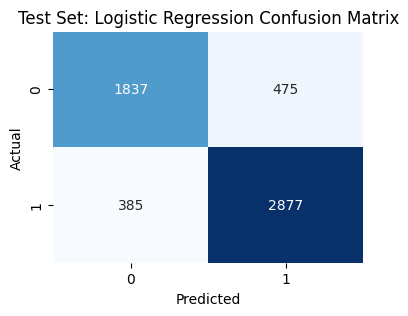


Evaluating Model: SVM
  Test Set Metrics:
    Accuracy: 0.8448
    Precision: 0.8524
    Recall: 0.8887
    F1: 0.8702
    Confusion Matrix:
[[1810  502]
 [ 363 2899]]


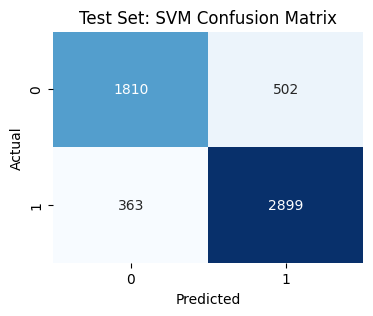


Evaluating Model: Decision Tree
  Test Set Metrics:
    Accuracy: 0.8348
    Precision: 0.8434
    Recall: 0.8814
    F1: 0.8619
    Confusion Matrix:
[[1778  534]
 [ 387 2875]]


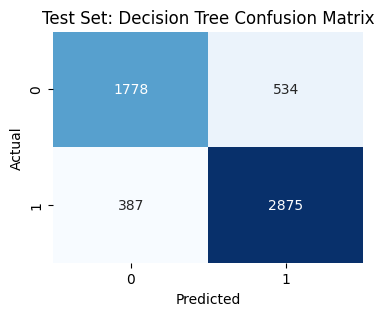


Evaluating Model: Random Forest
  Test Set Metrics:
    Accuracy: 0.8414
    Precision: 0.8485
    Recall: 0.8875
    F1: 0.8675
    Confusion Matrix:
[[1795  517]
 [ 367 2895]]


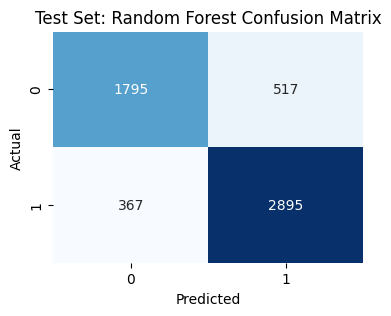


Evaluating Model: XGBoost
  Test Set Metrics:
    Accuracy: 0.8493
    Precision: 0.8602
    Recall: 0.8866
    F1: 0.8732
    Confusion Matrix:
[[1842  470]
 [ 370 2892]]


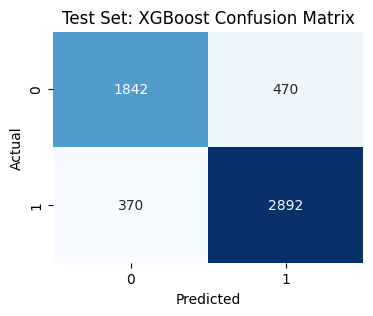


Evaluating Model: TabNetClassifier
  Test Set Metrics:
    Accuracy: 0.8470
    Precision: 0.8647
    Recall: 0.8755
    F1: 0.8701
    Confusion Matrix:
[[1865  447]
 [ 406 2856]]


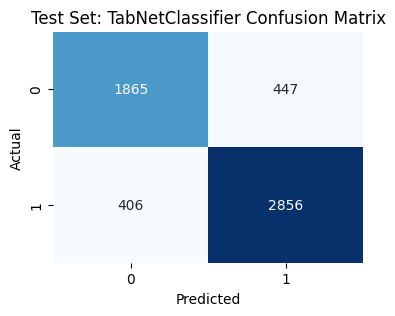


Evaluating Model: AutoML
  Test Set Metrics:
    Accuracy: 0.8498
    Precision: 0.8603
    Recall: 0.8875
    F1: 0.8737
    Confusion Matrix:
[[1842  470]
 [ 367 2895]]


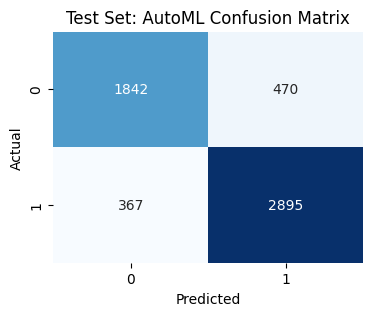


Evaluating Model: Clusstering_density
Error during model evaluation (sklearn): This 'Pipeline' has no attribute 'predict'
  Evaluation returned None or invalid metrics for model: Clusstering_density

Evaluating Model: Clusstering_mean
  Test Set Metrics:
    Accuracy: 0.8396
    Precision: 0.8460
    Recall: 0.8875
    F1: 0.8662
    Confusion Matrix:
[[1785  527]
 [ 367 2895]]


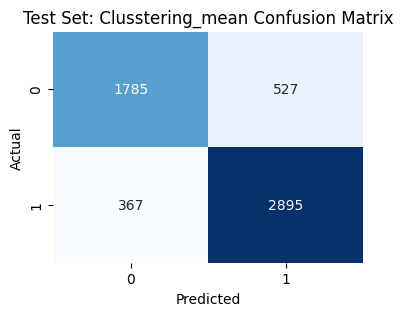


Evaluating Model: ANN
  Test Set Metrics:
    Accuracy: 0.8423
    Precision: 0.8508
    Recall: 0.8860
    F1: 0.8680
    Confusion Matrix:
[[1805  507]
 [ 372 2890]]


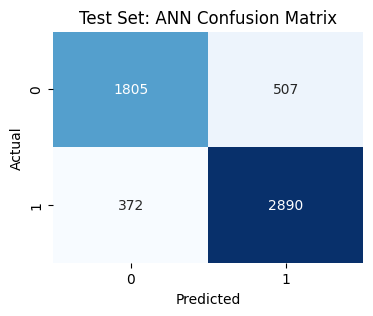


Evaluating Model: Ensemble
  Test Set Metrics:
    Accuracy: 0.8455
    Precision: 0.8542
    Recall: 0.8875
    F1: 0.8705
    Confusion Matrix:
[[1818  494]
 [ 367 2895]]


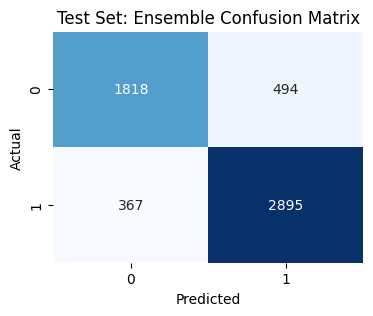


Evaluating Model: Stacking (LR+RF)
  Test Set Metrics:
    Accuracy: 0.8504
    Precision: 0.8590
    Recall: 0.8906
    F1: 0.8745
    Confusion Matrix:
[[1835  477]
 [ 357 2905]]


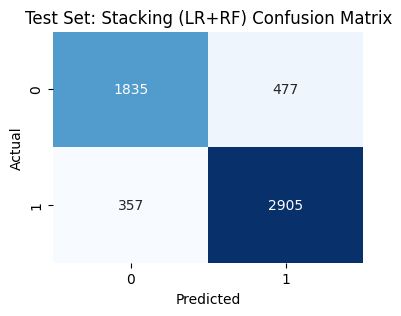

In [48]:
import matplotlib.pyplot as plt

print("\n--- Evaluating All Models on Test Set ---\n")
all_test_metrics = {}

for model_name, model_info in results.items():
    print(f"\nEvaluating Model: {model_name}")
    
    model = model_info.get('model', None)
    preprocessor = model_info.get('preprocessor', None)

    if model is None:
        print(f"  Skipping {model_name} – model object is missing or None.")
        continue

    try:
        if model_name == 'ANNs':
            if preprocessor is None:
                print("  ANN model's preprocessor is missing. Skipping.")
                continue
            metrics = evaluate_model(model, X_test.copy(), y_test.copy(), 
                                     preprocessor=preprocessor, model_type='pytorch')
        else:
            metrics = evaluate_model(model, X_test.copy(), y_test.copy(), model_type='sklearn')

        if metrics is not None and isinstance(metrics, dict):
            all_test_metrics[model_name] = metrics
            print("  Test Set Metrics:")
            for metric, value in metrics.items():
                if metric != 'Confusion Matrix':
                    print(f"    {metric}: {value:.4f}")
                else:
                    print(f"    {metric}:\n{value}")
            plot_confusion(metrics['Confusion Matrix'], f"Test Set: {model_name} Confusion Matrix")
        else:
            print(f"  Evaluation returned None or invalid metrics for model: {model_name}")

    except Exception as e:
        print(f"  Error while evaluating {model_name}: {e}")

In [49]:
all_test_metrics

{'Logistic Regression': {'Accuracy': 0.8457122353785432,
  'Precision': 0.8582935560859188,
  'Recall': 0.8819742489270386,
  'F1': 0.869972785001512,
  'Confusion Matrix': array([[1837,  475],
         [ 385, 2877]])},
 'SVM': {'Accuracy': 0.8448152134912091,
  'Precision': 0.8523963540135254,
  'Recall': 0.8887185775597792,
  'F1': 0.870178598229026,
  'Confusion Matrix': array([[1810,  502],
         [ 363, 2899]])},
 'Decision Tree': {'Accuracy': 0.8347685683530678,
  'Precision': 0.8433558228219419,
  'Recall': 0.881361128142244,
  'F1': 0.8619397391695398,
  'Confusion Matrix': array([[1778,  534],
         [ 387, 2875]])},
 'Random Forest': {'Accuracy': 0.8414065303193398,
  'Precision': 0.8484759671746777,
  'Recall': 0.8874923359901901,
  'F1': 0.8675456997302967,
  'Confusion Matrix': array([[1795,  517],
         [ 367, 2895]])},
 'XGBoost': {'Accuracy': 0.8493003229278795,
  'Precision': 0.8602022605591909,
  'Recall': 0.8865726548129982,
  'F1': 0.8731884057971014,
  'Conf

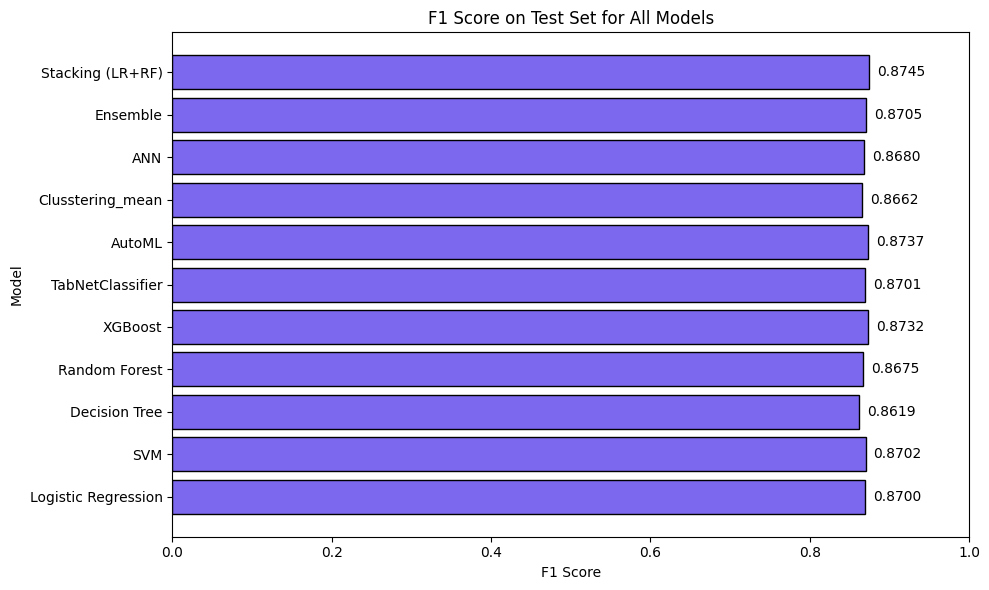

In [50]:
f1_scores = {model: metrics['F1'] 
             for model, metrics in all_test_metrics.items() 
             if isinstance(metrics, dict) and 'F1' in metrics}

if f1_scores:
    models = list(f1_scores.keys())
    scores = list(f1_scores.values())

    plt.figure(figsize=(10, 6))
    bars = plt.barh(models, scores, color='mediumslateblue', edgecolor='black')
    plt.ylabel('Model')
    plt.xlabel('F1 Score')
    plt.title('F1 Score on Test Set for All Models')
    plt.xlim(0, 1)

    # Annotate each bar with the F1 score
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f"{width:.4f}",
                ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo F1 scores available to plot.")

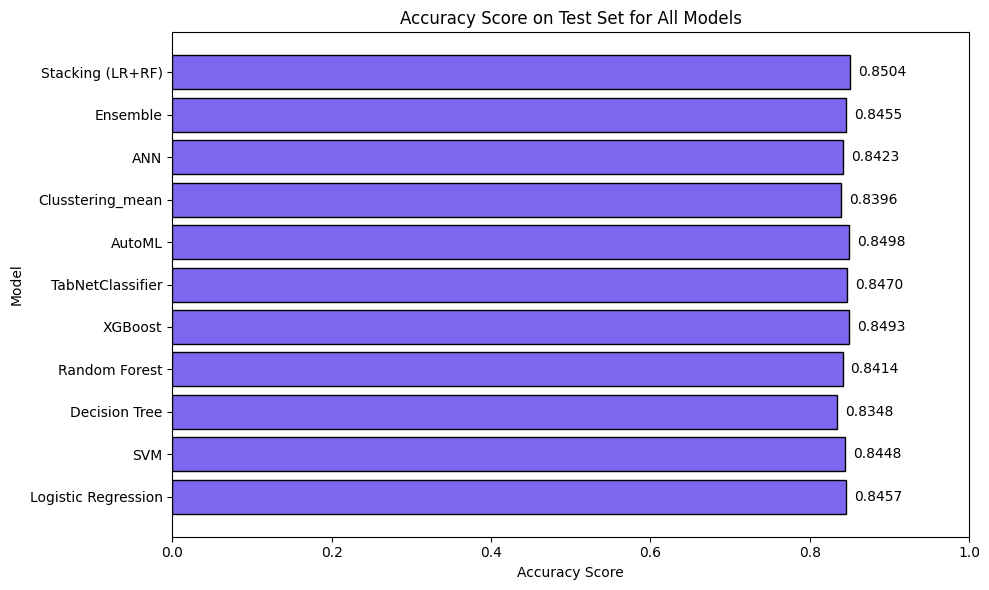

In [51]:
f1_scores = {model: metrics['Accuracy'] 
             for model, metrics in all_test_metrics.items() 
             if isinstance(metrics, dict) and 'Accuracy' in metrics}

if f1_scores:
    models = list(f1_scores.keys())
    scores = list(f1_scores.values())

    plt.figure(figsize=(10, 6))
    bars = plt.barh(models, scores, color='mediumslateblue', edgecolor='black')
    plt.ylabel('Model')
    plt.xlabel('Accuracy Score')
    plt.title('Accuracy Score on Test Set for All Models')
    plt.xlim(0, 1)

    # Annotate each bar with the F1 score
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f"{width:.4f}",
                ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo F1 scores available to plot.")

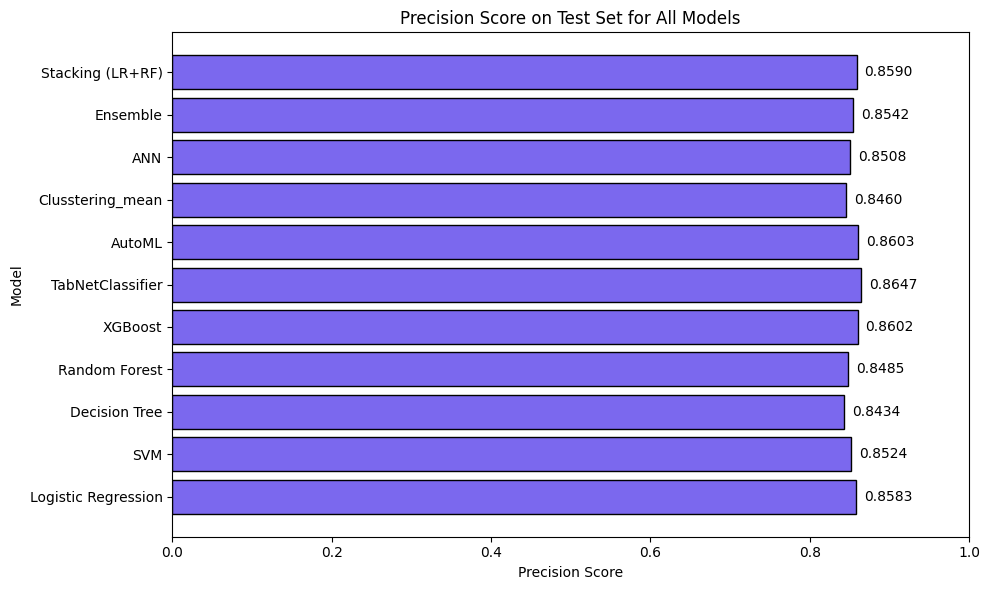

In [52]:
f1_scores = {model: metrics['Precision'] 
             for model, metrics in all_test_metrics.items() 
             if isinstance(metrics, dict) and 'Precision' in metrics}

if f1_scores:
    models = list(f1_scores.keys())
    scores = list(f1_scores.values())

    plt.figure(figsize=(10, 6))
    bars = plt.barh(models, scores, color='mediumslateblue', edgecolor='black')
    plt.ylabel('Model')
    plt.xlabel('Precision Score')
    plt.title('Precision Score on Test Set for All Models')
    plt.xlim(0, 1)

    # Annotate each bar with the F1 score
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f"{width:.4f}",
                ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo F1 scores available to plot.")

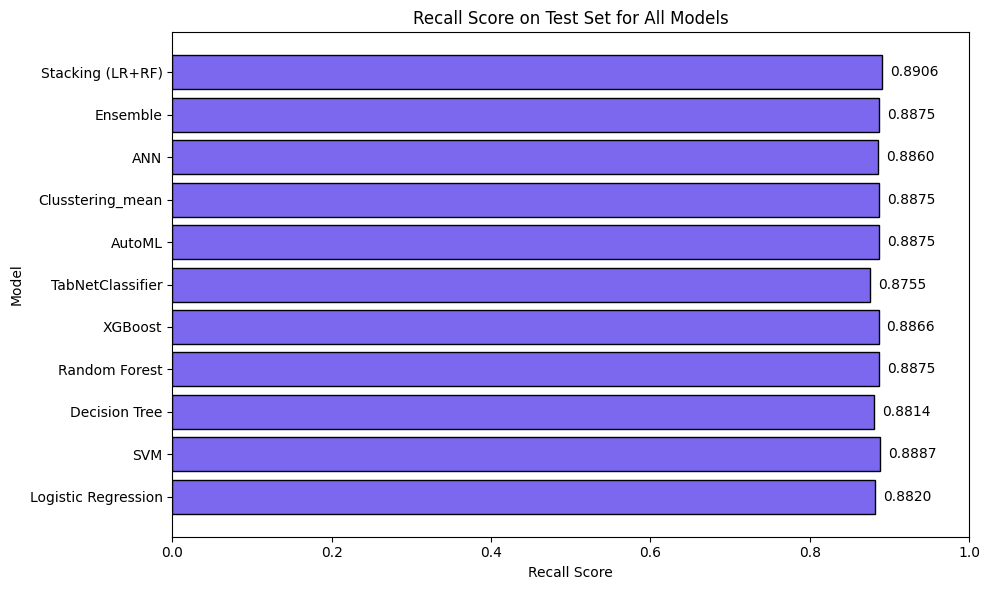

In [53]:
f1_scores = {model: metrics['Recall'] 
             for model, metrics in all_test_metrics.items() 
             if isinstance(metrics, dict) and 'Recall' in metrics}

if f1_scores:
    models = list(f1_scores.keys())
    scores = list(f1_scores.values())

    plt.figure(figsize=(10, 6))
    bars = plt.barh(models, scores, color='mediumslateblue', edgecolor='black')
    plt.ylabel('Model')
    plt.xlabel('Recall Score')
    plt.title('Recall Score on Test Set for All Models')
    plt.xlim(0, 1)

    # Annotate each bar with the F1 score
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f"{width:.4f}",
                ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo F1 scores available to plot.")

In [57]:
shap_vals[0]

array([ 0.10485714,  0.        ,  0.13642857,  0.        , -0.00878571,
        0.00447619,  0.        ,  0.        , -0.00271429,  0.        ,
        0.22052381,  0.05633333, -0.06761905,  0.        , -0.0035    ])